In [1]:
# Notebook configuration

ALGODIRECT_HNSW_RESULTS_DIR = "./results/algodirect/jacob/"

GT_DIR = "/private/nas1/fvs_benchmark_datasets" # requires nfs mount

In [4]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [5]:
#
# Algo Direct - HNSW
#

In [12]:
# Accumulate algodirect gemini results by recursively walking the results dir

csvs = []

# locate a .json files in the results data dir
for root, dir, files in os.walk(ALGODIRECT_HNSW_RESULTS_DIR):
    for file in files:
        
        if file.endswith(".csv"):
            fpath = os.path.join(root, file)
            csvs.append(fpath)

#print(csvs)

In [16]:
# Load all hnsw csv results into one dataframe

dfs = []

for csvfile in csvs:
    # parse the file name for info
    _df = pd.read_csv(csvfile)
    parts = os.path.basename(csvfile).split("_")
    print(parts)
    if parts[2]=="work": continue
    _df['implementation']=parts[1]
    _df['machine']=parts[2]
    _df['dset']="deep-"+parts[3]  # TODO: make sure to change for different base dataset
    _df['numrecs']=int(parts[4])
    _df['ef']=int(parts[5])
    _df['importtime']=float(parts[6])
    _df['walltime']=float(parts[7].split(".")[0])
    dfs.append(_df)

df = pd.concat(dfs)
print(df.columns, df.shape)

['algodirect', 'hnsw', 'fractals-1', '5M', '5000000', '64', '4884.424269', '4886.168362.csv']
['algodirect', 'hnsw', 'work', '2M', '2000000', '64', '816.926898', '817.292186.csv']
['algodirect', 'hnsw', 'fractals-1', '10K', '10000', '64', '1.413711', '1.415308.csv']
['algodirect', 'hnsw', 'fractals-1', '2M', '2000000', '128', '1365.490693', '1366.108399.csv']
['algodirect', 'hnsw', 'fractals-1', '2M', '2000000', '256', '1365.490693', '1366.108399.csv']
['algodirect', 'hnsw', 'fractals-1', '1M', '1000000', '256', '508.257080', '508.539452.csv']
['algodirect', 'hnsw', 'work', '2M', '2000000', '512', '816.926898', '817.292186.csv']
['algodirect', 'hnsw', 'fractals-1', '1M', '1000000', '128', '508.257080', '508.539452.csv']
['algodirect', 'hnsw', 'fractals-1', '5M', '5000000', '512', '4884.424269', '4886.168362.csv']
['algodirect', 'hnsw', 'work', '1M', '1000000', '512', '328.976568', '329.134567.csv']
['algodirect', 'hnsw', 'fractals-1', '2M', '2000000', '64', '1365.490693', '1366.108399.

In [17]:
# Show the data

pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
#df

In [18]:
# compute recall via GT file

print(df.columns, df.shape)

# get all unique dataset sizes
sizes = df['numrecs'].unique()
sizes.sort()
print("all sizes=",sizes)

# get all unique bit sizes
efs = df['ef'].unique()
efs.sort()
print("all efs=",efs)

# create empty ecall10 column to be computed shortly
df['recall10']= None

def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    else: raise Exception("Unsupported size" + str(numrecs))


# accumulate summaries for new dataframe
summaries = []

for ef in efs:
    for sz in sizes:
        # get the ground truth file for this numrecs size
        hsz = hsize(sz)
        gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % hsz)
        if not os.path.exists(gt_file):
            raise Exception("Cannot find "+ gt_file)
        gt = np.load(gt_file)
        #print(gt_file, gt.shape)
    
        # get the rows for this numrecs size
        df_sz = df[ (df['numrecs']==sz) & \
                    (df['ef']==ef) ]
        if df_sz.shape[0]==0:
            print("Nothing for bits=%d and numrecs=%d" % (ef, sz))
            continue
        elif df_sz.shape[0]!=1000:
            print("Warning: multiple runs across query set (%d,%d)" % \
                (ef,sz))
            
        # iterate all rows and compute recall
        for i in range(df_sz.shape[0]):
            # get query index
            q_i = df_sz.iloc[i, list(df.columns).index('q_index') ]
            # get the search indices for this query index
            inds = [ int(ith) \
                for ith in \
                    df_sz.iloc[i, list(df.columns).index('inds')]
                        .replace("=","-").split("-") ]
            #print(q_i)
            # get the associated ground truth indices for this query for k=10
            gt10 = gt[q_i][0:10]
            # compute intersection for recall
            isec = np.intersect1d( gt10, inds)
            recall10 = len(isec)/10.0
            # apply to this row
            df_sz.at[i,'recall10'] = recall10
    
        # compute mean recall
        recall10_mean = df_sz['recall10'].mean()
    
        # compute mean search time 
        search_mean = (df_sz['search_time'].mean() / 1000000000.0) * 1000.0
    
        # grab the train time
        import_time = df_sz['importtime'].mean() / 1000000000.0
        
        # grab the wall import time
        wall_time = df_sz['walltime'].mean() / 1000000000.0
        
        #print(bt, sz, recall10_mean, search_mean, train_time, wall_time )
        summary = {'ef':ef, 'numrecs':sz, \
                   'recall10_mean': recall10_mean, \
                   'search_mean': search_mean, \
                   'import_time': import_time, \
                   'wall_time': wall_time }
        summaries.append(summary)

summary_df = pd.DataFrame(summaries)
print(summary_df)

print("Done")

Index(['ts', 'q_index', 'search_time', 'inds', 'implementation', 'machine',
       'dset', 'numrecs', 'ef', 'importtime', 'walltime'],
      dtype='object') (16000, 11)
all sizes= [  10000 1000000 2000000 5000000]
all efs= [ 64 128 256 512]
     ef  numrecs  recall10_mean   search_mean   import_time     wall_time
0    64    10000         0.9958  1.663620e-10  1.413711e-09  1.000000e-09
1    64  1000000         0.9537  6.387930e-10  5.082571e-07  5.080000e-07
2    64  2000000         0.9417  1.039223e-09  1.365491e-06  1.366000e-06
3    64  5000000         0.9336  1.257046e-09  4.884424e-06  4.886000e-06
4   128    10000         0.9992  2.348090e-10  1.413711e-09  1.000000e-09
5   128  1000000         0.9790  1.210025e-09  5.082571e-07  5.080000e-07
6   128  2000000         0.9741  1.639630e-09  1.365491e-06  1.366000e-06
7   128  5000000         0.9664  1.863788e-09  4.884424e-06  4.886000e-06
8   256    10000         1.0000  4.260130e-10  1.413711e-09  1.000000e-09
9   256  1000000   

train time [10000, 1000000, 2000000, 5000000] [3.926974999999999e-13, 1.4118252222222225e-10, 3.7930297027777776e-10, 1.3567845191666666e-09]
wall import time [10000, 1000000, 2000000, 5000000] [2.777777777777778e-13, 1.4111111111111113e-10, 3.7944444444444444e-10, 1.3572222222222223e-09]


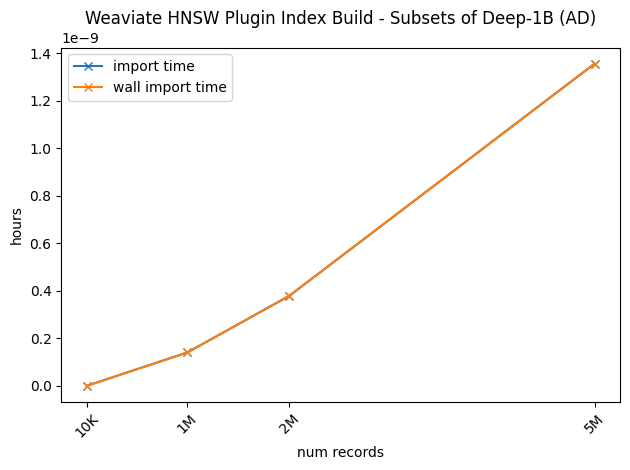

In [19]:
# Plot import/train times

# compute average train time via groupby
avg_import_time = \
    summary_df.groupby( [ 'numrecs' ] ) ['import_time'].mean()

# compute average wall import time via groupby
avg_wall_import_time = \
    summary_df.groupby( [ 'numrecs' ] ) ['wall_time'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_import_time.index:
    x = idx
    xs.append(x)
    y = avg_import_time[idx]/(60.0*60.0)
    ys.append(y)
print("train time", xs,ys)

# get the plot points for wall import time
wxs = []
wys = []
for idx in avg_wall_import_time.index:
    x = idx
    wxs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    wys.append(y)
print("wall import time", wxs,wys)

# plot the lines and label the plot
fig, ax = plt.subplots()
ax.plot(xs,ys, marker='x', label="import time")
ax.plot(wxs,wys, marker='x', label="wall import time")
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)
ax.set_xticklabels(['10K','1M','2M','5M'], rotation = 45)
ax.set_title("Weaviate HNSW Plugin Index Build - Subsets of Deep-1B (AD)")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_hnsw_build_time_ad.png")

# TODO:  plot the variance at each X

[0.9957999999999996, 0.953699999999997, 0.9416999999999971, 0.9335999999999967] [1.66362e-10, 6.38793e-10, 1.039223e-09, 1.257046e-09]
[0.9992, 0.9789999999999976, 0.9740999999999983, 0.9663999999999973] [2.3480900000000003e-10, 1.210025e-09, 1.63963e-09, 1.8637879999999996e-09]
[1.0, 0.9919999999999991, 0.9887999999999987, 0.9852999999999985] [4.2601300000000004e-10, 1.8774560000000002e-09, 2.870577e-09, 3.872434e-09]
[1.0, 0.9964999999999995, 0.9954999999999994, 0.9925999999999993] [8.144640000000001e-10, 3.634712e-09, 4.771605e-09, 7.470598e-09]


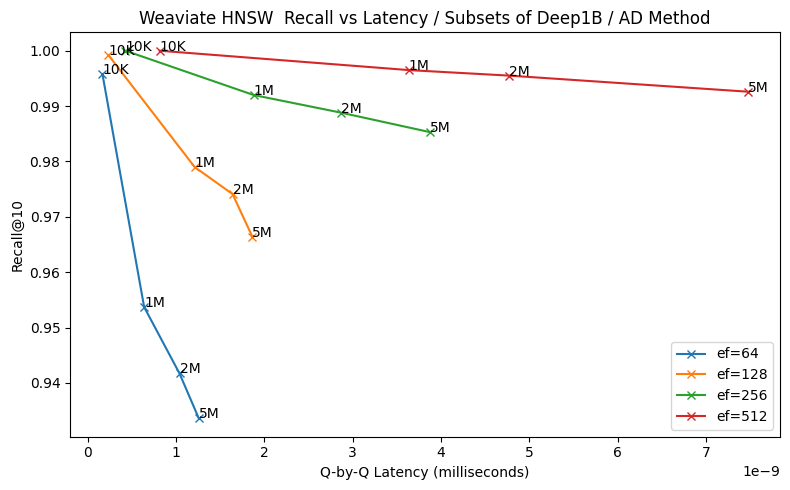

In [20]:
# plot Weaviate recall vs latency

# get unique gem bit sizes
efs = summary_df['ef'].unique()

# prepare one plot
fig, ax = plt.subplots(figsize=(8,5))

# collect data points for the line for each bit size and plot each line
for ef in efs: # we don't need to show 512 and 768

    # TODO:  Needs a CPUs inner loop
    
    # compute mean of average recall_10 grouped by num records
    df_means = \
        summary_df[ summary_df['ef']==ef ]\
            .groupby( [ 'numrecs' ] )\
            .mean(['recall_10','search_mean'])
 
    dset_sizes = [ idx for idx in list(df_means.index) ]
    dset_sizes.sort()
    #print(dset_sizes)

    # get the plot points for recall vs latency
    recalls = [ r for r in list(df_means['recall10_mean']) ]
    latencies = [ l for l in list(df_means['search_mean']) ]
    print(recalls, latencies)

    # plot the line
    ax.plot(latencies,recalls, marker='x', label='ef=%d' % ef)

    # label each point
    for i,j,s in zip(latencies,recalls,dset_sizes):
        off = (0,0)
        ax.annotate(hsize(s),  xy=(i + off[0], j + off[1]))

ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
ax.set_title("Weaviate HNSW  Recall vs Latency / Subsets of Deep1B / AD Method")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_hnsw_recall_vs_latency_ad.png")
